# Creating a Neural-Network from scratch
> A tutorial to code a neural network from scratch in python using numpy.

- toc: false
- badges: true
- comments: true
- categories: [machinelearning deeplearning python3.x numpy]
- image: images/backprop.jpeg

I will assume that you all know what a artificial neural network is and have a little bit of knowledge about `forward and backward propagation`. Just having a simple idea is enough.

> Tip: If you do not know what the above terms are or would like to brush up on the topics, I would suggest going through this amazing [youtube playlist](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) by [3Blue1Brown](https://www.3blue1brown.com/).

> youtube: https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi

## Setting up Imports:

In [1]:
import numpy as np
import gzip
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#hide_input
import warnings
np.random.seed(123)
%matplotlib inline
warnings.filterwarnings("ignore")

## Preparing the data

For this blog post, we'll use one of the most famous datasets in computer vision, [MNIST](https://en.wikipedia.org/wiki/MNIST_database). MNIST contains images of handwritten digits, collected by the National Institute of Standards and Technology and collated into a machine learning dataset by Yann Lecun and his colleagues. Lecun used MNIST in 1998 in [Lenet-5](http://yann.lecun.com/exdb/lenet/), the first computer system to demonstrate practically useful recognition of handwritten digit sequences. This was one of the most important breakthroughs in the history of AI.

Run the code given below to download the `MNIST` dataset.

```shell
wget -P path http://deeplearning.net/data/mnist/mnist.pkl.gz
```

> Note: the above code snippet will download the dataset to `{path}` so be sure to set the `{path}` to the desired location of your choice. 

In [3]:
def get_data(path):
    """
    Fn to unzip the MNIST data and return
    the data as numpy arrays
    """
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(np.array, (x_train,y_train,x_valid,y_valid))


# Grab the MNIST dataset
x_train,y_train,x_valid,y_valid = get_data(path= "../../Datasets/mnist.pkl.gz")

tots,feats = x_train.shape
print("Shape of x_train:",x_train.shape)
print("Total number of examples:", tots)
print("Number of pixel values per image:", feats)

Shape of x_train: (50000, 784)
Total number of examples: 50000
Number of pixel values per image: 784


## Preparing our `train` & `validation` datasets

To make our life a bit easier we are going to take only the examples that contain a 1 or 0.

In [4]:
zero_mask = [y_train==0] # grab all the index values where 0 is present
one_mask = [y_train==1] # grad all the index valus where 1 is present

# grab all the 1's and 0's and make training set
x_train = np.vstack((x_train[zero_mask], x_train[one_mask]))
y_train = np.reshape(y_train, (-1,1))
y_train = np.squeeze(np.vstack((y_train[zero_mask], y_train[one_mask]))).reshape(-1,1)

x_train.shape, y_train.shape

((10610, 784), (10610, 1))

**Our training set now has 10610 examples**

In [5]:
zero_mask = [y_valid==0] # grab all the index values where 0 is present
one_mask = [y_valid==1] # grad all the index valus where 1 is present

# grab all the 1's and 0's and make training set
x_valid = np.vstack((x_valid[zero_mask], x_valid[one_mask]))
y_valid = np.reshape(y_valid, (-1,1))
y_valid = np.squeeze(np.vstack((y_valid[zero_mask], y_valid[one_mask]))).reshape(-1,1)

x_valid.shape, y_valid.shape

((2055, 784), (2055, 1))

**Our validation set now has 2055 examples**

**Why do we need different training and validation sets ?**

Since, this topic requires a different post on it's own I won't be covering it here. But you can get the idea from this above video:

> youtube: https://youtu.be/1waHlpKiNyY?t=243

Let's view some example images from our dataset:

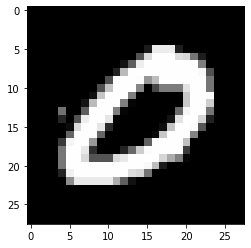

In [6]:
#collapse 
plt.imshow(x_train[50].reshape(28,28), cmap="gray");

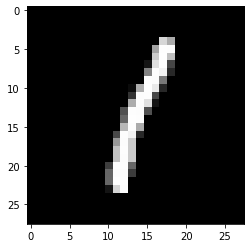

In [7]:
#collapse
plt.imshow(x_train[5000].reshape(28,28), cmap="gray");

## Basic Model Architecture

For this task we are going to use a very basic model architecture this 2 linear layers and a output layer with 1 unit.

In [8]:
#hide_input 
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"' + s + '; }')

## Let's take a deep dive into what this network means:

Let's take at look at all the individual components of this network:
- **Linear:**
  The linear layer computes the following :      
   ```
   out = matmul(input,W1) + B1
   ```
   
- **ReLU:** 
  The relu computes the following:
  ```
  out = max(0, input)
  ```
- **Sigmoid:** 
  The sigmoid computes the following:
  ```
  out = 1/(1 + e.pow(input))
  ```
  
- **Loss:** 
  For the loss we are going to use the CrossEntropy Loss which is defined by the follwoing equation:
  $$loss= -\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(yhat^{(i)}\right) + (1-y^{(i)})\log\left(1-yhat^{(i)}\right)) $$

**Now that we have our model architecture, let's create the different parts needed to assemble the model:**
- linear layer
- relu activation
- sigmoid activation
- loss

**Let's first try to make some sense of what is happening in the backward and forward pass of our model:**

**On paper our forward pass would look something like this:**

> Note: `@` in python is the `matrix-multiplication operator`. 

```python
inputs = x_train # original inputs
targets = y_train # original targets

# forward pass for the 1st linear layer
z1 = inputs @ w2 + b2
a1 = relu(z1)
# forward pass for the 2nd linear layer
z2 = a1 @ w2 + b2
a2 = relu(z2)
# forward pass for the output linear layer
z3 = a2 @ w3 + b3
pred = a3 = sigmoid(z3) # these are our model predictions 
# calculate loss between original targets & model predictions
loss = loss_fn(a3, targets)
```
> Note: This is not actual code it's just psuedo-code for understanding.

**Forward pass :**

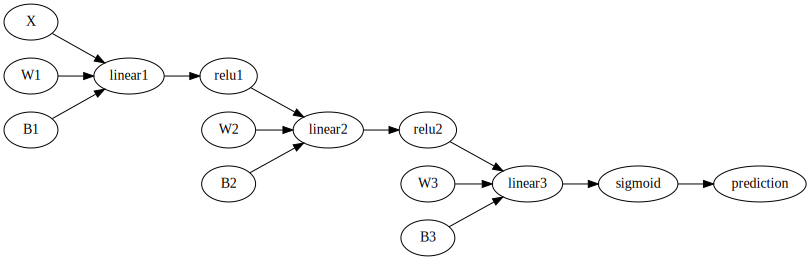

In [30]:
#hide_input
gv('''
X->linear1->relu1->linear2->relu2->linear3->sigmoid->prediction

W1->linear1
B1->linear1

W2->linear2
B2->linear2

W3->linear3
B3->linear3
''')

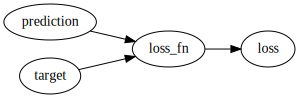

In [34]:
#hide_input
gv('''
prediction->loss_fn
target->loss_fn
loss_fn-> loss
''')

**Consequently our backward pass would look something like this :** 

(Let us assume that the `grad(inp, out)` computes the gradients of `inp` wrt `out`)

```python
# gradient of loss wrt to the output of the last activation layer: (a3)
# (or the predictions of model)
da3 = grad(loss, a3)

# gradient of loss wrt to the output of the current linear layer: (z3)
dz3 = grad(loss, z3) = grad(loss, a3) * grad(a3, z3)
# gradient of loss wrt to w3
dw3 = grad(loss, w3) = grad(loss, z3) * grad(z3, w3) = dz3 * grad(z3, w3)
# gradient of loss wrt to b3
db3 = grad(loss, b3) = grad(loss, z3) * grad(z3, b3) = dz3 * grad(z3, b3)
# gradient of loss wrt to the input of the current linear layer: (a2)
da2 = grad(loss, a2) = grad(loss, a3) = grad(a2, )

# gradient of loss wrt to the output of the current linear layer: (z2)
dz2 = grad(loss, z2) = grad(loss, a2) * grad(a2, z2) 
# gradient of loss wrt to w2
dw2 = grad(loss, w2) = grad(loss, z2) * grad(z2, w2) = dz2 * grad(z2, w2)
# gradient of loss wrt to b2
db2 = grad(loss, b2) = grad(loss, z2) * grad(z2, b2) = dz2 * grad(z2, b2)
# gradient of loss wrt to the input of the current linear layer: (a1)
da1 = grad(loss, a1) = grad(loss, z2) * grad(z2, a1) = dz2 * grad(z2, a1)

# gradient of loss wrt to the output of the current linear layer: (z1)
dz1 = grad(loss, z1) = grad(loss, a1) * grad(a1, z1) = da1 * grad(a1, z1)
# gradient of loss wrt to w1
dw1 = grad(loss, w1) = grad(loss, z1) * grad(z1, w1) = dz1 * grad(z1, w1)
# gradient of loss wrt to b1
db1 = grad(loss, b1) = grad(loss, z1) * grad(z1, 1) = dz1 * grad(z1, b1)
# In this layer the inputs are out training examples which we cannot change so
# we do not need to commpute more gradients

# Update parameters :
# since we now have all the required gradients we can now perform the update step
w1 -= learning_rate * dw1
b1 -= learning_rate * db1

w2 -= learning_rate * dw2
b2 -= learning_rate * db2
```
> Note: This is not actual code it's just psuedo-code for understanding.

**Backward pass:**

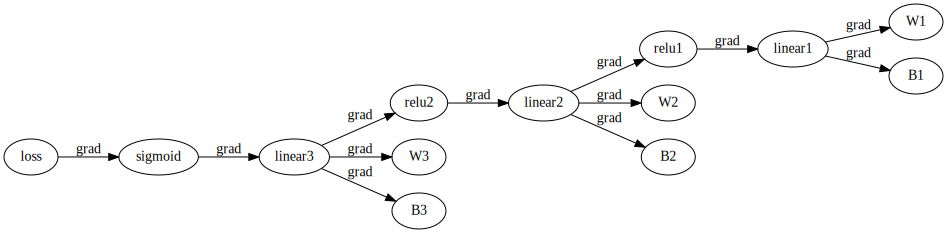

In [47]:
#hide_input
gv('''
loss -> sigmoid->linear3->relu2->linear2->relu1->linear1[label=grad]

linear3->W3[label=grad]
linear3->B3[label=grad]

linear2->W2[label=grad]
linear2->B2[label=grad]

linear1->W1[label=grad]
linear1->B1[label=grad]
''')

### The `Linear` Layer 

Below code creates a `Linear class` which represents a `Linear` layer in our neural-network. The `forward function` of the class implements the of the `layer's forward propagation` & the `backward function` implements the `layers's backward propagation`. Let's go to detail into what the code means:

- **Forward:**  
This part is quite straight-forward it computes the dot-product between the **`input`** and the **`weights`** & adds the **`bias`** term to get **`z`**. It also stores all the intermidiate values generated to use in the backward pass.


- **Backward:**
    * The backward method of the class **`Linear`** takes in the argument **`grads`**. 
    * **`grads`** is the gradient of the loss wrt to the output of the current linear layer ie., **`dz`** if we were to follow the nomenclature of our pseudo-code.
    * To succesfully compute the backward pass for our linear layer we need the following:
        - **`grad(z, w)`** 
        - **`grad(z, b)`**
        - **`grad(z, a_prev)`**



> Note: `z`, `w`, `b`, `a_prev` are the outputs, weights, bias and input-activations of the Linear layer respectively.

In [11]:
class Linear:
    def __init__(self, w, b):
        self.w = w
        self.b = b
        
    def forward(self, inp):
        """
        Implement the linear part of a layer's forward propagation.
        
        Args:
            inp : activations from previous layer (or input data)
        
        Returns:

            z  : the input of the activation function, also called pre-activation parameter 
        """
        self.inp = inp
        self.z   = inp @ self.w + self.b
        return self.z
    
    def backward(self, grads):
        """
        Implement the linear portion of backward propagation for a single layer.

        Args:
            grads :  Gradient of the cost with respect to the linear output. 
                     or the accumulated gradients from the prev layers. 
                     This is used for the chain rule to compute the gradients.
        Returns:
            da : Gradient of cost wrt to the activation of the previous layer or the input of the 
                 current layer.
            dw : Gradient of the cost with respect to W
            db : Gradient of the cost with respect to b
        """
        m = self.inp.shape[1]
        # gradient of loss wrt to the weights
        dw = 1/m * (self.inp.T @ grads)
        # gradient of the loss wrt to the bias
        db = 1/m * np.sum(grads, axis=0, keepdims=True)
        # gradient of the loss wrt to the input of the linear layer
        # this is used to continue the chain rule
        da_prev = grads @ self.w.T 
        return (da_prev, dw, db)

### The `ReLU` Layer

- **Forward**:  
The mathematical formula for ReLU is $A = RELU(Z) = max(0, Z)$
- **Backward**:  
During the backward pass the relu accepts the gradients of the `loss wrt to the activation` i.e, `da` then computes
the gradients of the `loss wrt to the input-of-relu(z)` i.e, `dz`.

In [12]:
class RelU:
    def forward(self, inp):
        """
        Implement the RELU function.

        Args:
            inp : Output of the linear layer, of any shape

        Returns:
            a  : Post-activation parameter, of the same shape as Z
        """
        self.inp = inp
        self.output = np.maximum(0, self.inp)
        return self.output
    
    def backward(self, grads):
        """
        Implement the backward propagation for a single RELU unit.

        Ars:
            grads : gradients of the loss wrt to the activation output

        Returns:
            dz : Gradient of the loss with respect to the input of the activation
        """
        dz = np.array(grads, copy=True)
        dz[self.inp <= 0] = 0
        return dz

### The `sigmoid` Layer

The sigmoid layer functions in exactly the same way as the `ReLU` layer . The only difference is the forward pass output calculation. 


In the `sigmoid layer`:  $\sigma(Z) = \frac{1}{ 1 + e^{-(W A + b)}}$

In [13]:
class Sigmoid:
    def forward(self, inp):
        """
        Implements the sigmoid activation in numpy

        Args:
            inp: numpy array of any shape

        Returns:
            a  : output of sigmoid(z), same shape as inp
        """
        self.inp = inp
        self.out =  1/(1+np.exp(-self.inp))
        return self.out
    
    def backward(self, grads):
        """
        Implement the backward propagation for a single sigmoid unit.

        Args:
            grads : gradients of the loss wrt to the activation output

        Returns:
            dz : Gradient of the loss with respect to the input of the activation
        """
        s = 1/(1+np.exp(-self.inp))
        dz = grads * s * (1-s)
        return dz

## `Loss` function :

For this task we are going to use the [CrossEntropy Loss](https://en.wikipedia.org/wiki/Cross_entropy)

The `forward` pass of the CrossEntropy Loss is computed as follows: 
$$loss= -\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(yhat^{(i)}\right) + (1-y^{(i)})\log\left(1-yhat^{(i)}\right)) $$

In [14]:
class CELoss():
    def forward(self, pred, target):
        """
        Implement the CrossEntropy loss function.

        Args:
            pred   : predicted labels from the neural network
            target : true "label" labels
        Returns:
            loss   : cross-entropy loss
        """
        self.yhat = pred
        self.y = target
        m = self.y.shape[0]
        # commpute loss
        term1 = (np.multiply(self.y, np.log(self.yhat)))
        term2 = (np.multiply((1-self.y),(np.log(1-self.yhat))))
        loss = -1/m * np.sum(term1+term2)
        self.output = loss
        return np.squeeze(self.output) # convert array to a single value number
    
    def backward(self):
        """
        Computes the gradinets of the loss_fn wrt to the predicted labels
        
        Returns:
         da : derivative of loss_fn wrt to the predicted labels
        """
        # derivative of loss_fn with respect to a [predicted labels]
        da = - (np.divide(self.y, self.yhat) - np.divide(1 - self.y, 1 - self.yhat)) 
        return da

## Model:

**Let's go over the architecture that we are going to use for our neural netwok:**

- Our model is going to have 2 hidden layers and a output layer. 
- The 2 `hidden layers` `(linear layers)` are going to have `16 units` each followed by a `ReLU` activation layer and the `output layer` `(linear layer)` is going to have `1 unit` followed by a `Sigmoid` unit. 
- The output layer is going to predict the `probability` of wether the given input is either a `0` or a `1`. If the predicted probability is `> 0.5 we` will assumse that the `predicted output` is `1` else `0`.

Let's assemble the layers required to construct out model:

**These are our inputs and targets:**

Shape of Inputs: (10610, 784)
Shape of Targets: (10610, 1)


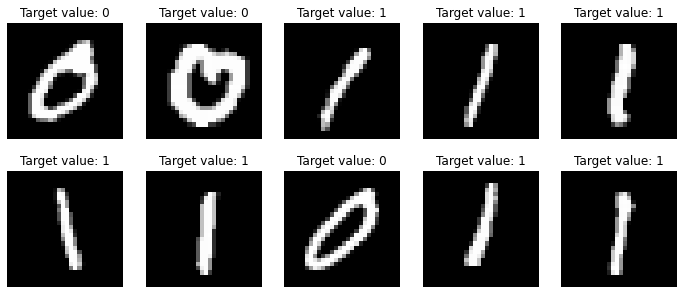

In [15]:
#collapse
print("Shape of Inputs:", x_train.shape)
print("Shape of Targets:", y_train.shape)

fig = plt.figure(figsize=(12,5))
for i in range(10):
    n = np.random.randint(len(x_train))
    val = x_train[n]
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(val.reshape(28,28), cmap="gray")
    plt.title(f"Target value: {y_train[n].squeeze()}")
    plt.axis("off")

**Initialize model parameters:**

In [16]:
#hide_output

nh1 = 16 # no. of units in the first hidden layer
nh2 = 16 # no. of units in the 2nd hidden layer
nh3 = 1 # no. of units in the output layer

w1  = np.random.randn(x_train.shape[1], nh1) * 0.01
b1  = np.zeros((1, nh1))

w2  = np.random.randn(nh1, nh2) * 0.01
b2  = np.zeros((1, nh2))

w3  = np.random.randn(nh2, nh3)
b3  = np.zeros((1, nh3))

w1.shape, b1.shape, w2.shape, b2.shape, w3.shape, b3.shape

((784, 16), (1, 16), (16, 16), (1, 16), (16, 1), (1, 1))

**Instaniating the layers needed to construct our model:**

In [17]:
lin1    = Linear(w1,b1) # 1 hidden layer
relu1   = RelU()
lin2    = Linear(w2,b2) # 2nd hidden layer
relu2   = RelU()
lin3    = Linear(w3,b3) # output layer
sigmoid = Sigmoid()

loss_fn = CELoss() # loss_fn

### Forward pass:

In [18]:
# forward pass
z1   = lin1.forward(x_train)
a1   = relu1.forward(z1)
z2   = lin2.forward(a1)
a2   = relu2.forward(z2)
z3   = lin3.forward(a2)
pred = a3 = sigmoid.forward(z3)

# calculate loss
loss = loss_fn.forward(pred, y_train)
print("Loss:", loss) # print out the loss

Loss: 0.6914281432245456


### Backward pass:

In [19]:
# backward pass
da3 = loss_fn.backward() # gradient of loss wrt to final output
dz3 = sigmoid.backward(da3)

da2, dw3, db3 = lin3.backward(dz3)

dz2 = relu2.backward(da2)
da1, dw2, db2 = lin2.backward(dz2)

dz1 = relu1.backward(da1)
_, dw1, db1 = lin1.backward(da1)

# check if the parameters and the gradients are of same shape
# so that we can preform the update state
assert lin1.w.shape == dw1.shape
assert lin2.w.shape == dw2.shape
assert lin3.w.shape == dw3.shape

assert lin1.b.shape == db1.shape
assert lin2.b.shape == db2.shape
assert lin3.b.shape == db3.shape

### Update parameters:

In [20]:
# set learning rate
learning_rate = 0.0002

# update parameters 
lin1.w -= learning_rate * dw1
lin2.w -= learning_rate * dw2
lin3.w -= learning_rate * dw3

lin1.b -= learning_rate * db1
lin2.b -= learning_rate * db2
lin3.b -= learning_rate * db3

So, this is how our training our model is going to look we first calculate the `loss` of the model during the `forward pass` , then we calculate the gradients of the `loss` wrt to the `parameters` of the model. After which these `gradients` are used to `update the model parameters`. We continue this workflow for a certain number of `iterations` or until our `loss` reaches the desired value.

Let's code up a class which will make this steps easir to achieve.

### Putting it all together:

- **Initializing parameters:**

In [21]:
#hide_output

# Instantiate parameters
nh1 = 16 # no. of units in the first hidden layer
nh2 = 16 # no. of units in the 2nd hidden layer
nh3 = 1 # no. of units in the output layer

w1  = np.random.randn(x_train.shape[1], nh1) * 0.01
b1  = np.zeros((1, nh1))

w2  = np.random.randn(nh1, nh2) * 0.01
b2  = np.zeros((1, nh2))

w3  = np.random.randn(nh2, nh3)
b3  = np.zeros((1, nh3))

w1.shape, b1.shape, w2.shape, b2.shape, w3.shape, b3.shape

((784, 16), (1, 16), (16, 16), (1, 16), (16, 1), (1, 1))

For our convenice, we will create a `Model` class . 

This `Model` class will store all the parameters for our neural-network.
The `forward` method will compute the `forward pass` of the network to generate the `loss` (and or `predictions`) of the model. The `backward` method will compute the `backward pass` of the network to get the gradinets of the `loss` wrt to the `parameters` of the model. Finally the `update` method will update the parameters of the model.

In [22]:
class Model:
    def __init__(self, learning_rate):
        """
        A simple neural network model
        The `forward` method computes the forward propagation step of the model
        The `backward` method computes the backward step propagation of the model
        The `update_step` method updates the parameters of the model
        """
        self.lin1    = Linear(w1,b1) # 1st linear layer
        self.relu1   = RelU()        # 1st activation layer
        self.lin2    = Linear(w2,b2) # 2nd linear layer
        self.relu2   = RelU()        # 2nd activation layer
        self.lin3    = Linear(w3,b3) # 3rd linear layer
        self.sigmoid = Sigmoid()     # 3rd activation layer
        self.loss_fn = CELoss()      # loss_fn
        
        # learning_rate to update model parameters
        self.lr      = learning_rate
        # stores the loss at each iteration
        self.losses  = [] 


    def forward(self, inp, calc_loss=True, targ=None):
        """
        Computs the forward step for out model Additionally
        it also returns the loss [Optional] and the predictions
        of the model.
        
        Args:
            inp       : the training set.
            calc_loss : wether to calculate loss of the model if False only predictions
                        are calculated.
            targ      : the original targets to the training set. 
        
        Note: to calculate the `loss` the `targ` must be given
        
        Returns:
            pred : outputs of the 3rd activation layer.
            loss : [Optional] loss the model , if the `targ` is given.
        """
        out  = self.relu1.forward(self.lin1.forward(inp))
        out  = self.relu2.forward(self.lin2.forward(out))
        pred = self.sigmoid.forward(self.lin3.forward(out))
        
        if calc_loss:
            assert targ is not None, "to calculate loss targets must be given"
            loss = self.loss_fn.forward(pred, targ)
            # appending the loss of the current iteration
            self.losses.append(loss)
            return loss, pred
        else:
            return pred
        
    def _assert_shapes(self):
        """
        Checks the shape of the parameters and the gradients of the model
        """
        assert lin1.w.shape == dw1.shape
        assert lin2.w.shape == dw2.shape
        assert lin3.w.shape == dw3.shape

        assert lin1.b.shape == db1.shape
        assert lin2.b.shape == db2.shape
        assert lin3.b.shape == db3.shape


    def backward(self):
        """
        Computes the backward step
        and return the gradients of the parameters with the loss
        """
        da3 = self.loss_fn.backward()
        dz3 = self.sigmoid.backward(da3)
        da2, dw3, db3 = self.lin3.backward(dz3)
        
        dz2 = self.relu2.backward(da2)
        da1, dw2, db2 = self.lin2.backward(dz2)

        dz1 = self.relu1.backward(da1)
        _, dw1, db1 = self.lin1.backward(dz1)
        
        self._assert_shapes()

        self.dws = [dw1, dw2, dw3]
        self.dbs = [db1, db2, db3]


    def update(self):
        """
        Performs the update step
        """
        self.lin1.w -= self.lr * self.dws[0]
        self.lin2.w -= self.lr * self.dws[1]
        self.lin3.w -= self.lr * self.dws[2]

        self.lin1.b -= self.lr * self.dbs[0]
        self.lin2.b -= self.lr * self.dbs[1]
        self.lin3.b -= self.lr * self.dbs[2]

In [23]:
nn = Model(learning_rate=0.0005)
epochs = 50 # no. of iterations to train

for n in range(epochs):
    loss, _ = nn.forward(x_train, calc_loss=True, targ=y_train)
    nn.backward()
    nn.update()
    print(f"Loss after interation {n} is {loss:.4f}")

Loss after interation 0 is 0.6924
Loss after interation 1 is 0.6900
Loss after interation 2 is 0.6859
Loss after interation 3 is 0.6826
Loss after interation 4 is 0.6760
Loss after interation 5 is 0.6683
Loss after interation 6 is 0.6565
Loss after interation 7 is 0.6415
Loss after interation 8 is 0.6190
Loss after interation 9 is 0.5894
Loss after interation 10 is 0.5532
Loss after interation 11 is 0.5110
Loss after interation 12 is 0.4643
Loss after interation 13 is 0.4128
Loss after interation 14 is 0.3635
Loss after interation 15 is 0.3164
Loss after interation 16 is 0.2747
Loss after interation 17 is 0.2389
Loss after interation 18 is 0.2086
Loss after interation 19 is 0.1834
Loss after interation 20 is 0.1624
Loss after interation 21 is 0.1448
Loss after interation 22 is 0.1300
Loss after interation 23 is 0.1174
Loss after interation 24 is 0.1068
Loss after interation 25 is 0.0976
Loss after interation 26 is 0.0897
Loss after interation 27 is 0.0828
Loss after interation 28 is 0.

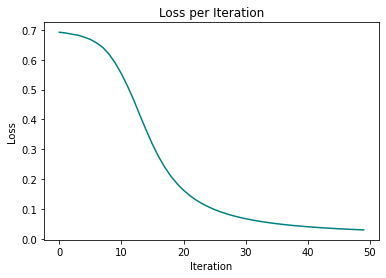

In [24]:
#collapse
plt.plot(nn.losses, color="teal")
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss");

## Computing accuracy of our model

**Let's check our model performance by computing the `accuracy` on the `validation` dataset**

In [25]:
def comp_accuracy(preds, targs):
    """
    Fn that computes the accuracy between the predicted values and the targets
    """
    m = len(targs)
    p = np.zeros_like(preds)
    # convert probas to 0/1 predictions
    for i in range(len(preds)):
        if preds[i] > 0.5:
            p[i] = 1
        else:
            p[i] = 0
    print("Accuracy: "  + str(np.sum((p == targs)/m)))    

computing accuracy on the train set:

In [26]:
preds = nn.forward(x_train, calc_loss=False) # generate predictions from our model
# compute accuracy
comp_accuracy(preds, y_train)

Accuracy: 0.9970782280867108


computing accuracy on the validation set:

In [27]:
preds = nn.forward(x_valid, calc_loss=False) # generate predictions from our model
# compute accuracy
comp_accuracy(preds, y_valid)

Accuracy: 0.997566909975669


> Note: our model achieved a `accuracy` of **`0.99`** on both the `train` and the `validation` set !

## Generating predictions from the model

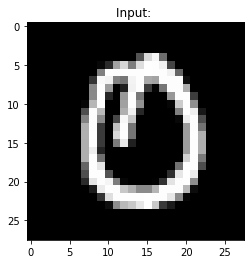

Predicted output: 0


In [28]:
#collapse
test_inp = x_valid[0] # one example from the validation set
plt.title("Input: ")

plt.imshow(test_inp.reshape(28,28), cmap="gray")
plt.show()

pred = nn.forward(test_inp, calc_loss=False)
predicted_val = int(pred > 0.5)
print(f"Predicted output: {predicted_val}")

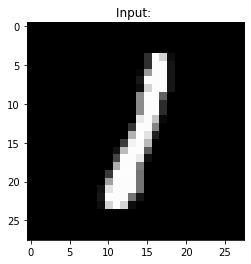

Predicted output: 1


In [29]:
#collapse
test_inp = x_valid[2000] # one example from the validation set
plt.title("Input: ")
plt.imshow(test_inp.reshape(28,28), cmap="gray")
plt.show()

pred = nn.forward(test_inp, calc_loss=False)
predicted_val = int(pred > 0.5)
print(f"Predicted output: {predicted_val}")

## Summary:

- We were able to create a model that can identify classify handwritten digits as either 1's or 0's
- We successfully computed the `forward` and `backward` progation of a `neural network` from scratch.

**Thanks for reading !**